In [1]:
import json

import numpy as np
import pandas as pd
from bidict import bidict
from keras.src.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from models.instrument_first_models import ANN_One, CNN_One
from utils.config import IRMAS_MFCC_Config
from utils.instrument_data import IRMASDataManipulator
import seaborn as sn

In [2]:
with open("../config.json") as json_data_file:
    general_config = json.load(json_data_file)

dataset_path = general_config["Philarmonia_Path_Alt"]

In [3]:
CLASS_DICTIONARY = bidict({
    0 : "banjo",
    1 : "bassoon",
    2 : "bass_clarinet",
    3 : "cello",
    4 : "clarinet",
    5 : "contrabassoon",
    6 : "cor_anglais",
    7 : "double_bass",
    8 : "flute",
    9 : "french_horn",
    10 : "guitar",
    11 : "mandolin",
    12 : "oboe",
    13 : "percussion",
    14 : "saxophone",
    15 : "trombone",
    16 : "trumpet",
    17 : "tuba",
    18 : "viola",
    19 : "violin",
})

66150
66150
13681


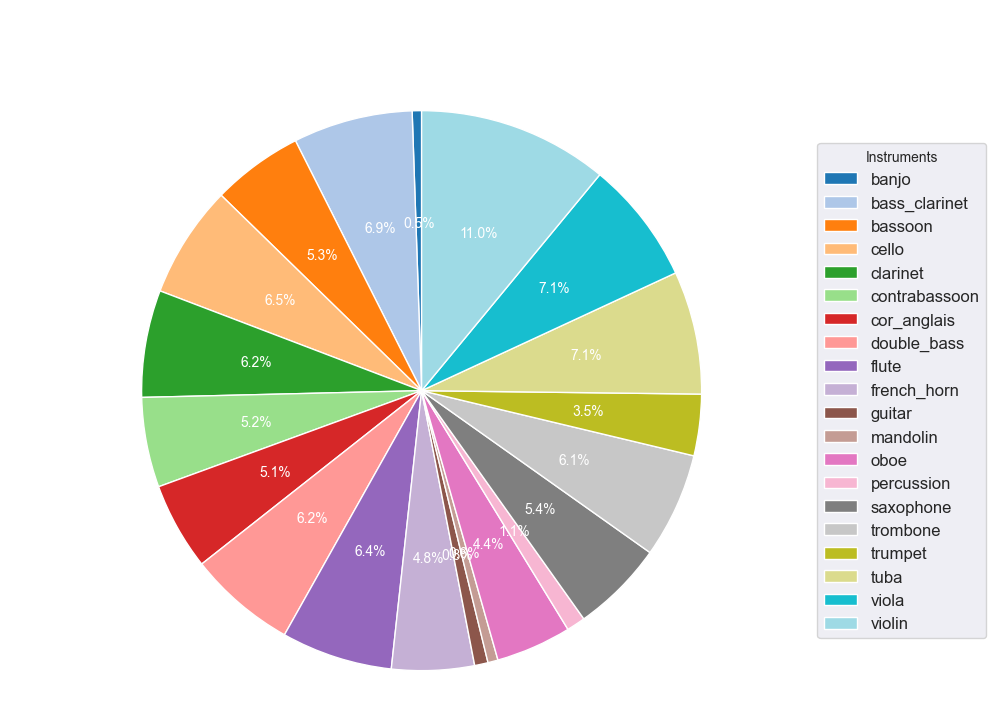

In [6]:
# Load the data
df = pd.read_csv('../statistics/philarmonia_complete_features.csv')
df.set_index('filename', inplace=True)

min_length = min(df["length"])
max_length = max(df["length"])
print(min_length)
print(max_length)
print(len(df))

# Compute class distribution
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].sum()

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Class Distribution', y=1.08, fontsize=16, fontweight='bold', color='white')

# Define a colormap
colors = plt.cm.tab20(np.arange(len(class_dist)) / len(class_dist))

# Draw the pie chart
wedges, texts, autotexts = ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90, colors=colors)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Customize text properties
for text in texts:
    text.set_color('white')
    text.set_fontsize(12)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)

# Adjust legend
ax.legend(wedges, class_dist.index, title="Instruments", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)

# Show the plot
plt.show()

# Calculate the number of samples
n_samples = 2 * int(df['length'].sum() / 0.1)  # a tenth of a second

# Probability distribution of each instrument being picked
prob_dist = class_dist / class_dist.sum()

In [5]:
config = IRMAS_MFCC_Config(model_path="../instrument_models/philarmonia_models/philarmonia_ann_libr.keras",
                           pickle_path="../instrument_pickles/pre_split/philarmonia_conv_libr.p")
data_manipulator = IRMASDataManipulator(config)

X, y = data_manipulator.build_data_for_CNN(dataset_path=dataset_path, df=df, classes=classes, input_type="librosa")
print("X shape : ", X.shape)
print("y shape : ", y.shape)  # one-hot encoded class matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)  # one-hot encoded class matrix

print("X_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)  # one-hot encoded class matrix

y_flat = np.argmax(y, axis=1)
input_shape = (X.shape[1], X.shape[2], 1)
print("ANN Input Shape : ", input_shape)

class_weight = compute_class_weight('balanced', classes=np.unique(y_flat), y=y_flat) # helps accuracy and loss by a small margin / reduces bias in the network

print(class_weight)

class_weight_dict = {index: value for index, value in enumerate(class_weight)}

print(class_weight_dict)

model_wrapper = CNN_One(input_shape=input_shape, output_shape=len(classes))
model_wrapper.create_model()

checkpoint = ModelCheckpoint(filepath=config.model_path+".keras", monitor='val_accuracy', verbose=1, mode="max", save_best_only=True,
                             save_weights_only=False)

history = model_wrapper.model.fit(X_train, y_train, epochs=10, batch_size=32, shuffle=True, validation_data=(X_test, y_test), callbacks=[checkpoint], class_weight=class_weight_dict)

model_wrapper.model.save(config.model_path)

Loading existing data for CNN_One model
X shape :  (13681, 13, 130, 1)
y shape :  (13681, 20)
X_train shape :  (10944, 13, 130, 1)
y_train shape :  (10944, 20)
X_test shape :  (2737, 13, 130, 1)
y_test shape :  (2737, 20)
ANN Input Shape :  (13, 130, 1)
[9.24391892 0.72462924 0.95006944 0.76946007 0.80856974 0.9634507
 0.98994211 0.80287559 0.77910023 1.04915644 6.45330189 8.550625
 1.1477349  4.62195946 0.93449454 0.82316486 1.41041237 0.70375514
 0.70303186 0.4554261 ]
{0: 9.243918918918919, 1: 0.7246292372881356, 2: 0.9500694444444444, 3: 0.7694600674915636, 4: 0.8085697399527186, 5: 0.9634507042253521, 6: 0.9899421128798842, 7: 0.8028755868544601, 8: 0.7791002277904328, 9: 1.0491564417177914, 10: 6.4533018867924525, 11: 8.550625, 12: 1.147734899328859, 13: 4.621959459459459, 14: 0.9344945355191256, 15: 0.823164861612515, 16: 1.4104123711340206, 17: 0.7037551440329218, 18: 0.7030318602261049, 19: 0.45542609853528626}


C:\Proiecte SSD\Licenta\Basic-Fourier-Usage\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 13, 130, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 130, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 130, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 130, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 65, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 65, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 49920)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,389,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,496,596 (24.78 MB)

 Trainable params: 6,496,596 (24.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.0362 - loss: 3.0194 - mse: 0.0475
Epoch 1: val_accuracy improved from -inf to 0.05079, saving model to instrument_models/philarmonia_models/philarmonia_ann_libr.keras.keras
342/342 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.0362 - loss: 3.0193 - mse: 0.0475 - val_accuracy: 0.0508 - val_loss: 2.9939 - val_mse: 0.0475
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.0389 - loss: 3.0111 - mse: 0.0475

KeyboardInterrupt: 

In [ ]:
model_wrapper.plot_history(history)

y_pred = model_wrapper.model.predict(X_test)

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=CLASS_DICTIONARY.values(), columns=CLASS_DICTIONARY.values())

# Set up the matplotlib figure size
plt.figure(figsize=(10, 7))  # You can adjust the size as needed

# Customize seaborn heatmap
sn.set(font_scale=1.4)  # Adjust font scale for better readability
heatmap = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='coolwarm')  # Using 'viridis' colormap

# Additional customizations
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=10)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('SVM Confusion Matrix')
plt.show()